<a href="https://colab.research.google.com/github/1kaiser/test2022/blob/main/MLPCopy_of_Untitled17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  run from here

### Model and training code

Our model is a coordinate-based multilayer perceptron. In this example, for each input image coordinate $(x,y)$, the model predicts the associated color $(r,g,b)$ or any $(gray)$.

![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)

[--xla_force_host_platform_device_count](https://jax.readthedocs.io/en/latest/jax-101/06-parallelism.html#:~:text=When%20running%20on-,CPU,-you%20can%20always)

In [1]:
#✅
import os
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=8'
import jax
jax.devices()

[CpuDevice(id=0),
 CpuDevice(id=1),
 CpuDevice(id=2),
 CpuDevice(id=3),
 CpuDevice(id=4),
 CpuDevice(id=5),
 CpuDevice(id=6),
 CpuDevice(id=7)]

In [2]:
#✅
import jax
import jax.numpy as jnp

positional_encoding_dims = 6  # Number of positional encodings applied

def positional_encoding(inputs):
    print("positional_encoding start")
    batch_size, _ = inputs.shape;print(inputs.shape)
    inputs_freq = jax.vmap(lambda x: inputs * 2.0 ** x)(jnp.arange(positional_encoding_dims));print(inputs_freq.shape)
    x = jnp.stack([jnp.sin(inputs_freq), jnp.cos(inputs_freq)]);print(x.shape)
    x = x.swapaxes(0, 2);print(x.shape)
    x = x.reshape([batch_size, -1]);print(x.shape)
    x = jnp.concatenate([inputs, x], axis=-1);print(x.shape)
    print("positional_encoding end")
    return x

# y = np.ones((256, 256, 3))
# print(y.shape)
# image_height, image_width, cha = y.shape
# size = image_height * image_width
# yt = np.ones((size, cha))
# print(yt.shape)
# positional_encoding(yt)


In [3]:
# positional_encoding_vmap = jax.vmap(positional_encoding)
# ######################################
# y = jnp.ones((8, 256, 256, 3))
# print(y.shape)
# batchsize, image_height, image_width, cha = y.shape
# size = image_height * image_width
# yt = jnp.ones((batchsize, size, cha))
# ######################################
# print("vmap >>>")
# print(positional_encoding_vmap(yt).shape)

# positional_encoding_pmap = jax.pmap(positional_encoding)
# print("pmap >>>")
# print(positional_encoding_pmap(yt).shape)

### MLP MODEL
Basically, passing input points through a simple Fourier Feature Mapping enables an MLP to learn high-frequency functions (such as an RGB image) in low-dimensional problem domains (such as a 2D coordinate of pixels).

In [4]:
#✅
!python -m pip install -q -U flax

import jax
import jax.numpy as jnp

import flax
import optax
from typing import Any

from jax import lax
import flax.linen as nn
from flax.training import train_state, common_utils
apply_positional_encoding = True # Apply posittional encoding to the input or not
num_dense_layers = 8 # Number of dense layers in MLP
dense_layer_width = 256 # Dimentionality of dense layers' output space 
##########################################<< MLP MODEL >>#########################################
class MLPModel(nn.Module):
    dtype: Any = jnp.float32
    precision: Any = lax.Precision.DEFAULT
    apply_positional_encoding: bool = apply_positional_encoding
    @nn.compact
    def __call__(self, input_points):
        x = positional_encoding(input_points) if self.apply_positional_encoding else input_points
        print("network model start")
        print(x.shape)
        for i in range(num_dense_layers):
            x = nn.Dense(
                dense_layer_width,
                dtype=self.dtype,
                precision=self.precision
                )(x)
            x = nn.relu(x)
            x = jnp.concatenate([x, input_points], axis=-1) if i == 4 else x
            print(x.shape)
  
        x = nn.Dense(1, dtype=self.dtype, precision=self.precision)(x)
        print(x.shape)
        print("network model end")
        return x



     |████████████████████████████████| 180 kB 7.0 MB/s 
     |████████████████████████████████| 217 kB 60.6 MB/s 
     |████████████████████████████████| 145 kB 60.5 MB/s 
     |████████████████████████████████| 51 kB 7.2 MB/s 
     |████████████████████████████████| 85 kB 4.1 MB/s 


In [5]:
#✅
# !wget https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz
# from google.colab import output
# output.clear() #to_clear_the_output_console_everytime
# import jax.numpy as jnp

# data = jnp.load("tiny_nerf_data.npz")
# images = data["images"]
# poses = data["poses"]
# focal = float(data["focal"])
# _, image_height, image_width, _ = images.shape
# train_images, train_poses = images[:100], poses[:100]
# val_image, val_pose = images[101], poses[101]
# ############################################
# def initialize_model(key, input_pts_shape):
#     model = MLPModel()
#     initial_params = jax.jit(model.init)({"params": key},jnp.ones(input_pts_shape),)
#     return model, initial_params["params"]
# #############################################
# n_devices = jax.local_device_count()
# key, rng = jax.random.split(jax.random.PRNGKey(0))
# model, params = initialize_model(key, (image_height * image_width, 3))


In [6]:
# #✅
# import jax.numpy as jnp
# import jax
# key, rng = jax.random.split(jax.random.PRNGKey(0))
# batch_size_no = 64
# x = jnp.ones(shape=(batch_size_no, 32, 32, 3)) # Dummy Input
# BATCH, image_height, image_width, channel = x.shape
# size = image_height * image_width
# yt = jnp.ones((size, channel))
# model = MLPModel() # Instantiate the Model

# params = model.init(rng, yt) # Initialize the parameters
# print(type(params))

# params1 = model.apply # Initialize the parameters
# print(type(params1))

# jax.tree_map(lambda x: x.shape, params) # Check the parameters


In [7]:
#@title MODEL SUMMARY { vertical-output: true }
#✅
# import flax.linen as nn
# nn.tabulate(model, rng)(jnp.ones((image_height * image_width, channels)))

### initialize the module

In [8]:
#✅
!python -m pip install -q -U flax
import optax
from flax.training import train_state
import jax.numpy as jnp
import jax


def init_train_state(model, r_key, shape, learning_rate ) -> train_state.TrainState:
    print(shape)
    # BATCH, image_height, image_width, cha = shape
    # size = image_height * image_width
    # yt = jnp.ones((size, cha))
    init_variables = model.init(r_key, jnp.ones(shape))  # Initialize the Model
    optimizer = optax.adam(learning_rate) # Create the optimizer
    # Create a State
    return train_state.TrainState.create(
        apply_fn = model.apply,
        tx=optimizer,
        params=init_variables['params']
    )

learning_rate = 1e-4
batch_size_no = 64
model = MLPModel() # Instantiate the Model
key, rng = jax.random.split(jax.random.PRNGKey(0))
x = jnp.ones(shape=(batch_size_no, 28, 28, 1)) # Dummy Input
_, image_height, image_width, channels = x.shape
state = init_train_state( model, rng, (image_height * image_width, channels), learning_rate )


(784, 1)
positional_encoding start
(784, 1)
(6, 784, 1)
(2, 6, 784, 1)
(784, 6, 2, 1)
(784, 12)
(784, 13)
positional_encoding end
network model start
(784, 13)
(784, 256)
(784, 256)
(784, 256)
(784, 256)
(784, 257)
(784, 256)
(784, 256)
(784, 256)
(784, 1)
network model end


In [9]:
def cross_entropy_loss(*, logits, labels):
    one_hot_encoded_labels = jax.nn.one_hot(labels, num_classes=10)
    return optax.softmax_cross_entropy(
        logits=logits, labels=one_hot_encoded_labels
    ).mean()
def compute_metrics(*, logits, labels):
  loss = .5 * jnp.mean((logits - labels) ** 2)
  loss = lax.pmean(loss, axis_name="batch");print("ok4")
  metrics = {
      'loss': loss,
  }
  return metrics

In [10]:
import jax
@jax.jit
def train_step(state: train_state.TrainState, batch: jnp.ndarray, rng):
    print(batch)
    image, label = batch
    print(image,"<<<image")
    print(label,"<<<label")    
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, image);print("done1",logits.shape)
        loss =  .5 * jnp.mean((logits - label) ** 2);print("done2",loss.shape)
        return loss, logits

    # def loss_fn(params):
    #     model_fn = lambda x: state.apply_fn({"params": params}, x)
    #     ray_origins, ray_directions = inputs
    #     print(ray_origins)
    #     print(ray_directions)
    #     rgb, *_ = perform_volume_rendering(
    #         model_fn, ray_origins, ray_directions, rng
    #     )
    #     return jnp.mean((rgb - targets) ** 2)  
    print("ok1really")
    gradient_fn = jax.value_and_grad(loss_fn, has_aux=True);print("ok1")
    (_, logits), grads = gradient_fn(state.params);print("ok2")
    #train_loss, gradients_each = jax.value_and_grad(loss_fn)(state.params);print("ok3")
    grads = lax.pmean(grads,"batch");print("ok4")
    # grads = jnp.mean(grads);print("ok4")
    state = state.apply_gradients(grads=grads);print("ok5")
    # train_loss = jnp.mean(train_loss);print("ok6")
    metrics = compute_metrics(logits=logits, labels=label);print("ok7")
    return state, metrics

parallel_train_step = jax.pmap(train_step, "batch")
# parallel_train_step = jax.pmap(train_step, axis_name="batch", in_axes = (0, 0, 0))

import jax
@jax.jit
def eval_step(state, batch):
    image, label = batch
    logits = state.apply_fn({'params': state.params}, image)
    return compute_metrics(logits=logits, labels=label)


### checkpoints management

In [11]:
def save_checkpoint(ckpt_path, state):
    with open(ckpt_path, "wb") as outfile:
        outfile.write(msgpack_serialize(to_state_dict(state)))
    


def load_checkpoint(ckpt_path, ckpt_file, state):
    ckpt_path = os.path.join(ckpt_path, ckpt_file)
    with open(ckpt_path, "rb") as data_file:
        byte_data = data_file.read()
    return from_bytes(state, byte_data)


def accumulate_metrics(metrics):
    metrics = jax.device_get(metrics)
    return {
        k: np.mean([metric[k] for metric in metrics])
        for k in metrics[0]
    }

### train & evaluation function

In [13]:
!gdown https://drive.google.com/uc?id=1UgWEotThxnP-Vh-h83-VcTPMkKWmgCDe #downloading MAP-DEM 

Downloading...
From: https://drive.google.com/uc?id=1UgWEotThxnP-Vh-h83-VcTPMkKWmgCDe
To: /content/HLSL30.020_B04_doy2021057_aid0001_43N.tif
100% 10.6M/10.6M [00:00<00:00, 87.7MB/s]


--2022-09-27 14:19:04--  https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg
Resolving live.staticflickr.com (live.staticflickr.com)... 18.160.38.87, 2600:9000:2199:4800:0:5a51:64c9:c681, 2600:9000:2199:fa00:0:5a51:64c9:c681, ...
Connecting to live.staticflickr.com (live.staticflickr.com)|18.160.38.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘a.jpg’

a.jpg                   [ <=>                ] 230.86K  --.-KB/s    in 0.01s   

2022-09-27 14:19:04 (20.4 MB/s) - ‘a.jpg’ saved [236398]

--2022-09-27 14:19:05--  https://static.ok.xxx/contents/albums/main/1920x1080/87000/87368/5407976.jpg
Resolving static.ok.xxx (static.ok.xxx)... 185.240.29.12, 185.240.29.13, 185.240.29.10, ...
Connecting to static.ok.xxx (static.ok.xxx)|185.240.29.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 161504 (158K) [image/jpeg]
Saving to: ‘b.jpg’

b.jpg               100%[===================>] 157.72K

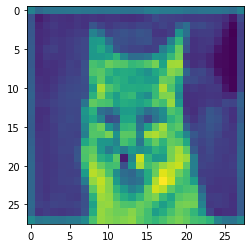

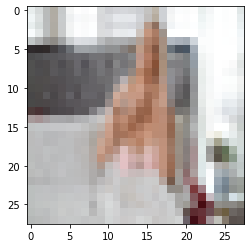

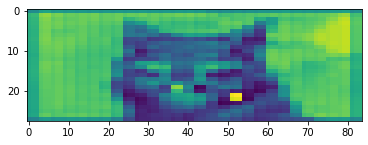

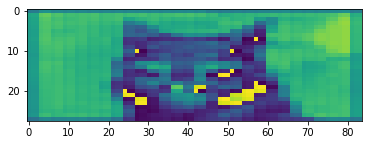

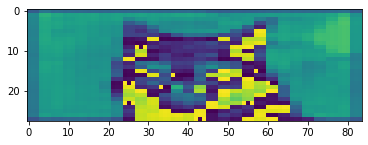

In [ ]:
#!wget https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg -O a.jpg

newsize = (28, 28)
from PIL import Image, ImageFilter
import jax.numpy as jnp

def imageGRAY(argv):
    im = Image.open(argv).convert('L')
    tvt, tvu = jnp.asarray(im.resize(newsize)),jnp.asarray(im.resize(newsize)).reshape(-1,1)
    return tvt, tvu
def imageRGB(argv):
    im = Image.open(argv)
    tvt, tvu = jnp.asarray(im.resize(newsize)),jnp.asarray(im.resize(newsize)).reshape(-1,3)
    return tvt, tvu
x, x1 = imageGRAY("/content/a.jpg")
print(x.shape)# mnist IMAGES are 28x28=784 pixels
y, y1 = imageRGB("/content/a.jpg")
print(y.shape,y1.shape,"<< y shape",x.shape,x1.shape,"<< y shape")# mnist IMAGES are 28x28=784 pixels
from matplotlib import pyplot as plt
plt.imshow(x);plt.show()
plt.imshow(y);plt.show()
plt.imshow((y1[0]-x1).reshape(28,-1));plt.show()
plt.imshow((y1[1]-x1).reshape(28,-1));plt.show()
plt.imshow((y1[2]-x1).reshape(28,-1));plt.show()


# batch = y1, x1  # jnp.ones((28*28,1)),jnp.ones((28*28,1)) OR jnp.ones((2, 28*28, 1))
# shapea, channels = y1.shape
# state = init_train_state( model, rng, (shapea, channels), learning_rate )
# for e in range(150):
#   state, metrics = train_step(state, batch, rng)
#   print(metrics)

In [ ]:
# #✅
# import os
# os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=8'
# import jax
# jax.devices()
# import jax.numpy as jnp
# from jax import pmap
# a = jnp.arange(8*10).reshape((8, 2,5))
# b = 2
# print(type(a));print(a)
# def f(x,y):a = x**2+y**2;return a
# ff = pmap(f, in_axes=(0,None))
# result = ff(a,b)
# print(type(result));print(result)
# num_devices = jax.device_count()

# shape_prefix = (num_devices, 1);print(shape_prefix)

In [ ]:
num_devices = jax.device_count()
ddy = jnp.asarray((y1,y1,y1,y1,y1,y1,y1,y1))       # rgb images (width * height, 3)
print(ddy.shape,"<<< ddy shape")
ddx = jnp.asarray((x1,x1,x1,x1,x1,x1,x1,x1))    #gray images (width * height, 1)
shape_prefix = (num_devices, 1);print(shape_prefix);print(ddy.shape,"<<<< ???")
# ddy = ddy.reshape(shape_prefix + ddy.shape[1:]);print(ddy.shape,"<< train_images_incorrect")
# ddx = ddx.reshape(shape_prefix + ddx.shape[1:]);print(ddx.shape,"<< train_images_incorrect")
batch = ddy, ddx  # jnp.ones((28*28,1)),jnp.ones((28*28,1)) OR jnp.ones((2, 28*28, 1))
print(len(batch),"<<< batch")
vv, shapea, channels = ddy.shape
######################
rng = jax.random.PRNGKey(0)
dropout_rngs = jax.random.split(rng, jax.local_device_count())
######################
state = init_train_state( model, rng, (shapea, channels), learning_rate )
state = flax.jax_utils.replicate(state)

for e in range(500):
  state, metrics = parallel_train_step(state, batch, dropout_rngs)
  print("<<✅✅✅epoc : ",e," complete✅✅✅>>\n",metrics)

(8, 784, 3) <<< ddy shape
(8, 1)
(8, 784, 3) <<<< ???
2 <<< batch
(784, 3)
positional_encoding start
(784, 3)
(6, 784, 3)
(2, 6, 784, 3)
(784, 6, 2, 3)
(784, 36)
(784, 39)
positional_encoding end
network model start
(784, 39)
(784, 256)
(784, 256)
(784, 256)
(784, 256)
(784, 259)
(784, 256)
(784, 256)
(784, 256)
(784, 1)
network model end
(Traced<ShapedArray(uint8[784,3])>with<DynamicJaxprTrace(level=0/2)>, Traced<ShapedArray(uint8[784,1])>with<DynamicJaxprTrace(level=0/2)>)
Traced<ShapedArray(uint8[784,3])>with<DynamicJaxprTrace(level=0/2)> <<<image
Traced<ShapedArray(uint8[784,1])>with<DynamicJaxprTrace(level=0/2)> <<<label
ok1really
ok1
positional_encoding start
(784, 3)
(6, 784, 3)
(2, 6, 784, 3)
(784, 6, 2, 3)
(784, 36)
(784, 39)
positional_encoding end
network model start
(784, 39)
(784, 256)
(784, 256)
(784, 256)
(784, 256)
(784, 259)
(784, 256)
(784, 256)
(784, 256)
(784, 1)
network model end
done1 (784, 1)
done2 ()
ok2
ok4
ok5
ok4
ok7
<<✅✅✅epoc :  0  complete✅✅✅>>
 {'loss': Sh

# ❌❌❌❌❌❌❌doesnot work >>>

In [ ]:
batch_size= 32
import datasets
train_images, train_labels, test_images, test_labels = datasets.mnist()
num_train = train_images.shape[0]
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)
import jax
num_devices = jax.device_count()
def data_stream():
  key, rng = jax.random.split(jax.random.PRNGKey(0))
  while True:
    perm = jax.random.permutation(rng, num_train); print(perm.shape)
    for i in range(num_batches):
      batch_idx = perm[i * batch_size:(i + 1) * batch_size]; print(batch_idx)
      images, labels = train_images[batch_idx], train_labels[batch_idx]; print(images.shape,"<< train_images_incorrect");print(labels.shape,"<< train_images_correct")
      # For this SPMD example, we reshape the data batch dimension into two
      # batch dimensions, one of which is mapped over parallel devices.
      batch_size_per_device, ragged = divmod(images.shape[0], num_devices);print(batch_size_per_device,"<<< batch_size_per_device")
      if ragged:
        msg = "batch size must be divisible by device count, got {} and {}."
        raise ValueError(msg.format(batch_size, num_devices))
      shape_prefix = (num_devices, batch_size_per_device);print(shape_prefix)
      images = images.reshape(shape_prefix + images.shape[1:]);print(images.shape,"<< train_images_incorrect")
      labels = labels.reshape(shape_prefix + labels.shape[1:]);print(labels.shape,"<< train_images_correct")
      return images, labels
batches = data_stream()


(60000,)
[26264 37070 41536 59687 11610 22771 23874 15255 54141 14461  2870 56657
 42265 36611 55946  2209  8936  5999 46173 10941 40884 37709 34074 48390
 51045 26399 38554 21339 33223  6021  3735 50198]
(32, 784) << train_images_incorrect
(32, 10) << train_images_correct
32 <<< batch_size_per_device
(1, 32)
(1, 32, 784) << train_images_incorrect
(1, 32, 10) << train_images_correct


In [ ]:
num_train_batches = tf.data.experimental.cardinality(train_dataset)
train_datagen = iter(tfds.as_numpy(train_dataset))
batch = next(train_datagen)
batch = jnp.ones((28*28,1)),jnp.ones((28*28,1))  # jnp.ones((28*28,1)),jnp.ones((28*28,1)) OR jnp.ones((2, 28*28, 1))
# state = flax.jax_utils.replicate(state)
state = init_train_state( model, rng, (image_height * image_width, channels), learning_rate )
for e in range(50):
  state, metrics = train_step(state, batch, rng)
  print(metrics)

(784, 1)
positional_encoding start
(784, 1)
(6, 784, 1)
(2, 6, 784, 1)
(784, 6, 2, 1)
(784, 12)
(784, 13)
positional_encoding end
network model start
(784, 13)
(784, 256)
(784, 256)
(784, 256)
(784, 256)
(784, 257)
(784, 256)
(784, 256)
(784, 256)
(784, 1)
network model end
(Traced<ShapedArray(float32[784,1])>with<DynamicJaxprTrace(level=0/1)>, Traced<ShapedArray(float32[784,1])>with<DynamicJaxprTrace(level=0/1)>)
Traced<ShapedArray(float32[784,1])>with<DynamicJaxprTrace(level=0/1)> <<<image
Traced<ShapedArray(float32[784,1])>with<DynamicJaxprTrace(level=0/1)> <<<label
ok1really
ok1
positional_encoding start
(784, 1)
(6, 784, 1)
(2, 6, 784, 1)
(784, 6, 2, 1)
(784, 12)
(784, 13)
positional_encoding end
network model start
(784, 13)
(784, 256)
(784, 256)
(784, 256)
(784, 256)
(784, 257)
(784, 256)
(784, 256)
(784, 256)
(784, 1)
network model end
done1 (784, 1)
done2 ()
ok2
ok5
ok7
{'loss': DeviceArray(0.50274664, dtype=float32)}
{'loss': DeviceArray(0.47457644, dtype=float32)}
{'loss': D

In [ ]:

def train_and_evaluate(train_dataset, eval_dataset, test_dataset, state: train_state.TrainState, epochs: int,):
    num_train_batches = tf.data.experimental.cardinality(train_dataset)
    num_eval_batches = tf.data.experimental.cardinality(eval_dataset)
    num_test_batches = tf.data.experimental.cardinality(test_dataset)
   
    for epoch in tqdm(range(1, epochs + 1)):
        best_eval_loss = 1e6
        # ============== Training ============== #
        train_batch_metrics = []
        train_datagen = iter(tfds.as_numpy(train_dataset))
        for batch_idx in range(num_train_batches):
            batch = next(train_datagen)
            state, metrics = train_step(state, batch, rng)
            train_batch_metrics.append(metrics)
        train_batch_metrics = accumulate_metrics(train_batch_metrics)
        print('TRAIN (%d/%d): Loss: %.4f' % (
                epoch, epochs, train_batch_metrics['loss'],
              ))
        # ============== Validation ============= #
        eval_batch_metrics = []
        eval_datagen = iter(tfds.as_numpy(eval_dataset))
        for batch_idx in range(num_eval_batches):
            batch = next(eval_datagen)
            metrics = eval_step(state, batch)
            eval_batch_metrics.append(metrics)
        eval_batch_metrics = accumulate_metrics(eval_batch_metrics)
        print('EVAL (%d/%d):  Loss: %.4f\n' % (
                epoch, epochs, eval_batch_metrics['loss'],
              ))    

        if eval_batch_metrics['loss'] < best_eval_loss:
            save_checkpoint("checkpoint.msgpack", state)

    restored_state = load_checkpoint("checkpoint.msgpack", state)
    test_batch_metrics = []
    test_datagen = iter(tfds.as_numpy(test_dataset))
    for batch_idx in range(num_test_batches):
        batch = next(test_datagen)
        metrics = eval_step(restored_state, batch)
        test_batch_metrics.append(metrics)
    
    test_batch_metrics = accumulate_metrics(test_batch_metrics)
    print(
        'Test: Loss: %.4f,' % (
            test_batch_metrics['loss'],
        )
    )
    # Log Metrics to Weights & Biases
    history = {
        "Train Loss": train_batch_metrics['loss'],
        "Validation Loss": eval_batch_metrics['loss'],
    }
    return state, restored_state, history



### loading 'mnist' data

In [ ]:
#@title @inproceedings{zhou2017scene, title={Scene Parsing through ADE20K Dataset}, author={Zhou, Bolei and Zhao, Hang and Puig, Xavier and Fidler, Sanja and Barriuso, Adela and Torralba, Antonio}, booktitle={Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition}, year={2017} }
#✅✅
import tensorflow_datasets as tfds
(full_train_set, test_dataset), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
validation_split = 0.2
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.
    return image, label



In [ ]:
#✅✅
import tensorflow as tf
batch_size = 64
full_train_set = full_train_set.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

num_data = tf.data.experimental.cardinality(full_train_set).numpy()
print("Total number of data points:", num_data)
train_dataset = full_train_set.take(num_data * (1 - validation_split))
val_dataset = full_train_set.take(num_data * (validation_split))
print("Number of train data points:",tf.data.experimental.cardinality(train_dataset).numpy())
print("Number of val data points:",tf.data.experimental.cardinality(val_dataset).numpy())
#############TRAIN##################
train_dataset = train_dataset.cache();print(len(train_dataset))
train_dataset = train_dataset.shuffle(tf.data.experimental.cardinality(train_dataset).numpy());print(train_dataset)
train_dataset = train_dataset.batch(batch_size);print(train_dataset)
#############TRAIN(EVALUATE)##################
val_dataset = val_dataset.cache()
val_dataset = val_dataset.shuffle(tf.data.experimental.cardinality(val_dataset).numpy())
val_dataset = val_dataset.batch(batch_size)

#############TEST##################
test_dataset = test_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
print("Number of test data points:",tf.data.experimental.cardinality(test_dataset).numpy())
test_dataset = test_dataset.cache()
test_dataset = test_dataset.batch(batch_size)

Total number of data points: 60000
Number of train data points: 48000
Number of val data points: 12000
48000
<ShuffleDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Number of test data points: 10000


In [ ]:
num_train_batches = tf.data.experimental.cardinality(train_dataset)
num_train_batches

<tf.Tensor: shape=(), dtype=int64, numpy=750>

### run inferences

In [ ]:
# state, inference_state, history = train_and_evaluate(state, parallelized_train_step, eval_step)


# train_dataset, eval_dataset, test_dataset, state, epochs
from tqdm.notebook import tqdm
epochs = 15
state, best_state, history = train_and_evaluate(
    train_dataset,
    val_dataset,
    test_dataset,
    state,
    epochs,
)

  0%|          | 0/15 [00:00<?, ?it/s]

(Traced<ShapedArray(float32[64,28,28,1])>with<DynamicJaxprTrace(level=0/1)>, Traced<ShapedArray(int32[64])>with<DynamicJaxprTrace(level=0/1)>)
Traced<ShapedArray(float32[64,28,28,1])>with<DynamicJaxprTrace(level=0/1)>
Traced<ShapedArray(int32[64])>with<DynamicJaxprTrace(level=0/1)>
ok1
positional_encoding start


ValueError: ignored

In [ ]:
train_dataset

# go

In [ ]:
import os
import time
import imageio
import requests
from typing import Any
import ipywidgets as widgets
from functools import partial
from tqdm.notebook import tqdm

!pip3 install -q -U flax

import jax
import flax
import optax
from jax import lax
import flax.linen as nn
from flax.training import train_state, common_utils


import numpy as np
import jax.numpy as jnp


from base64 import b64encode
from IPython.display import HTML
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid


In [ ]:
# Reference: https://www.kaggle.com/code/odins0n/jax-flax-tf-data-vision-transformers-tutorial


# Detect if Kaggle Notebook has access to TPUs or not
if 'TPU_NAME' in os.environ:
    import requests
    if 'TPU_DRIVER_MODE' not in globals():
        url = 'http:' + os.environ['TPU_NAME'].split(':')[1] + ':8475/requestversion/tpu_driver_nightly'
        resp = requests.post(url)
        TPU_DRIVER_MODE = 1
    from jax.config import config
    jax_xla_backend = "tpu_driver"
    jax_backend_target = os.environ['TPU_NAME']
    print("TPU DETECTED!")
    print('Registered TPU:', jax_backend_target)


# Detect if Google Colab Notebook has access to TPUs or not
elif "COLAB_TPU_ADDR" in os.environ:
    import jax.tools.colab_tpu
    jax.tools.colab_tpu.setup_tpu()


else:
    print('No TPU detected.')


DEVICE_COUNT = len(jax.local_devices())
TPU = DEVICE_COUNT==8


if TPU:
    print("8 cores of TPU ( Local devices in Jax ):")
    print('\n'.join(map(str,jax.local_devices())))


No TPU detected.


In [ ]:


# sync all experiment configs with Weights and Biases

near_bound = 2. # Near Bound of sample space for 3d points
far_bound = 6.  # Far Bound of sample space for 3d points
batch_size = int(1e4) # Batch Size
num_sample_points = 256 # Number of points to be sampled across the volume
epsilon = 1e10 # Hyperparameter for volume rendering
apply_positional_encoding = True # Apply posittional encoding to the input or not
positional_encoding_dims = 3 # Number of positional encodings applied
num_dense_layers = 5 # Number of dense layers in MLP
dense_layer_width = 256 # Dimentionality of dense layers' output space 
learning_rate = 5e-4 # Learning Rate
train_epochs = 1000 # Number of training epochs
plot_interval = 100 # Epoch interval for plotting results during training


In [ ]:
positional_encoding_dims = 3 # Number of positional encodings applied
def positional_encoding(inputs):
    batch_size, _ = inputs.shape;                                                   print(inputs.shape)
    # Applying vmap transform to vectorize the multiplication operation
    f = jax.vmap(lambda x: inputs * 2.0 ** x)(jnp.arange(positional_encoding_dims));print(f.shape)
    fy = jnp.stack([jnp.sin(f), jnp.cos(f)]);                                       print(fy)
    fy = fy.swapaxes(0, 2).reshape([batch_size, -1]);                               print(fy)
    fy = jnp.concatenate([inputs, fy], axis=-1);                                    print(fy)
    return fy


(10000, 3)


(3, 10000, 3)

Traced<ShapedArray(float32[2,3,10000,3])>with<DynamicJaxprTrace(level=0/1)>

Traced<ShapedArray(float32[10000,18])>with<DynamicJaxprTrace(level=0/1)>

Traced<ShapedArray(float32[10000,21])>with<DynamicJaxprTrace(level=0/1)>

# test mnist pmap gpu 1000 epocs runtime 9 minutes

In [ ]:
%%writefile datasets.py
# Copyright 2018 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Datasets used in examples."""


import array
import gzip
import os
from os import path
import struct
import urllib.request

import numpy as np


_DATA = "/tmp/jax_example_data/"


def _download(url, filename):
  """Download a url to a file in the JAX data temp directory."""
  if not path.exists(_DATA):
    os.makedirs(_DATA)
  out_file = path.join(_DATA, filename)
  if not path.isfile(out_file):
    urllib.request.urlretrieve(url, out_file)
    print(f"downloaded {url} to {_DATA}")


def _partial_flatten(x):
  """Flatten all but the first dimension of an ndarray."""
  return np.reshape(x, (x.shape[0], -1))


def _one_hot(x, k, dtype=np.float32):
  """Create a one-hot encoding of x of size k."""
  return np.array(x[:, None] == np.arange(k), dtype)


def mnist_raw():
  """Download and parse the raw MNIST dataset."""
  # CVDF mirror of http://yann.lecun.com/exdb/mnist/
  base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"

  def parse_labels(filename):
    with gzip.open(filename, "rb") as fh:
      _ = struct.unpack(">II", fh.read(8))
      return np.array(array.array("B", fh.read()), dtype=np.uint8)

  def parse_images(filename):
    with gzip.open(filename, "rb") as fh:
      _, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
      return np.array(array.array("B", fh.read()),
                      dtype=np.uint8).reshape(num_data, rows, cols)

  for filename in ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz",
                   "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]:
    _download(base_url + filename, filename)

  train_images = parse_images(path.join(_DATA, "train-images-idx3-ubyte.gz"))
  train_labels = parse_labels(path.join(_DATA, "train-labels-idx1-ubyte.gz"))
  test_images = parse_images(path.join(_DATA, "t10k-images-idx3-ubyte.gz"))
  test_labels = parse_labels(path.join(_DATA, "t10k-labels-idx1-ubyte.gz"))

  return train_images, train_labels, test_images, test_labels


def mnist(permute_train=False):
  """Download, parse and process MNIST data to unit scale and one-hot labels."""
  train_images, train_labels, test_images, test_labels = mnist_raw()

  train_images = _partial_flatten(train_images) / np.float32(255.)
  test_images = _partial_flatten(test_images) / np.float32(255.)
  train_labels = _one_hot(train_labels, 10)
  test_labels = _one_hot(test_labels, 10)

  if permute_train:
    perm = np.random.RandomState(0).permutation(train_images.shape[0])
    train_images = train_images[perm]
    train_labels = train_labels[perm]

  return train_images, train_labels, test_images, test_labels

Writing datasets.py


[datasets](https://github.com/google/jax/blob/main/examples/datasets.py) link

[spmd_mnist_classifier_fromscratch](https://github.com/google/jax/blob/main/examples/spmd_mnist_classifier_fromscratch.py) link

In [ ]:
# Copyright 2018 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""An MNIST example with single-program multiple-data (SPMD) data parallelism.

The aim here is to illustrate how to use JAX's `pmap` to express and execute
SPMD programs for data parallelism along a batch dimension, while also
minimizing dependencies by avoiding the use of higher-level layers and
optimizers libraries.
"""


from functools import partial
import time

import numpy as np
import numpy.random as npr

import jax
from jax import jit, grad, pmap
from jax.scipy.special import logsumexp
from jax.tree_util import tree_map
from jax import lax
import jax.numpy as jnp
import datasets
from google.colab import output


def init_random_params(scale, layer_sizes, rng=npr.RandomState(0)):
  return [(scale * rng.randn(m, n), scale * rng.randn(n))
          for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

def predict(params, inputs):
  activations = inputs
  for w, b in params[:-1]:
    outputs = jnp.dot(activations, w) + b
    activations = jnp.tanh(outputs)

  final_w, final_b = params[-1]
  logits = jnp.dot(activations, final_w) + final_b
  return logits - logsumexp(logits, axis=1, keepdims=True)

def loss(params, batch):
  inputs, targets = batch
  preds = predict(params, inputs)
  return -jnp.mean(jnp.sum(preds * targets, axis=1))

@jit
def accuracy(params, batch):
  inputs, targets = batch
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(predict(params, inputs), axis=1)
  return jnp.mean(predicted_class == target_class)


if __name__ == "__main__":
  layer_sizes = [784, 1024, 1024, 10]
  param_scale = 0.1
  step_size = 0.001
  num_epochs = 1000
  batch_size = 128

  train_images, train_labels, test_images, test_labels = datasets.mnist()
  num_train = train_images.shape[0]
  num_complete_batches, leftover = divmod(num_train, batch_size)
  num_batches = num_complete_batches + bool(leftover)

  # For this manual SPMD example, we get the number of devices (e.g. GPUs or
  # TPU cores) that we're using, and use it to reshape data minibatches.
  num_devices = jax.device_count()
  def data_stream():
    rng = npr.RandomState(0)
    while True:
      perm = rng.permutation(num_train)
      for i in range(num_batches):
        batch_idx = perm[i * batch_size:(i + 1) * batch_size]
        images, labels = train_images[batch_idx], train_labels[batch_idx]
        # For this SPMD example, we reshape the data batch dimension into two
        # batch dimensions, one of which is mapped over parallel devices.
        batch_size_per_device, ragged = divmod(images.shape[0], num_devices)
        if ragged:
          msg = "batch size must be divisible by device count, got {} and {}."
          raise ValueError(msg.format(batch_size, num_devices))
        shape_prefix = (num_devices, batch_size_per_device)
        images = images.reshape(shape_prefix + images.shape[1:])
        labels = labels.reshape(shape_prefix + labels.shape[1:])
        yield images, labels
  batches = data_stream()

  @partial(pmap, axis_name='batch')
  def spmd_update(params, batch):
    grads = grad(loss)(params, batch)
    # We compute the total gradients, summing across the device-mapped axis,
    # using the `lax.psum` SPMD primitive, which does a fast all-reduce-sum.
    grads = [(lax.psum(dw, 'batch'), lax.psum(db, 'batch')) for dw, db in grads]
    return [(w - step_size * dw, b - step_size * db)
            for (w, b), (dw, db) in zip(params, grads)]

  # We replicate the parameters so that the constituent arrays have a leading
  # dimension of size equal to the number of devices we're pmapping over.
  init_params = init_random_params(param_scale, layer_sizes)
  replicate_array = lambda x: np.broadcast_to(x, (num_devices,) + x.shape)
  replicated_params = tree_map(replicate_array, init_params)

  for epoch in range(num_epochs):
    start_time = time.time()
    for _ in range(num_batches):
      replicated_params = spmd_update(replicated_params, next(batches))
    epoch_time = time.time() - start_time

    # We evaluate using the jitted `accuracy` function (not using pmap) by
    # grabbing just one of the replicated parameter values.
    params = tree_map(lambda x: x[0], replicated_params)
    train_acc = accuracy(params, (train_images, train_labels))
    test_acc = accuracy(params, (test_images, test_labels))
    output.clear() #to_clear_the_output_console_everytime
    print(f"Epoch {epoch} in {epoch_time:0.2f} sec")
    print(f"Training set accuracy {train_acc}")
    print(f"Test set accuracy {test_acc}")